In [1]:

#importing necessary libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('/content/nyc_energy_consumption.csv')

In [3]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [5]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [6]:
fig = px.line(df, x='timeStamp', y='demand', title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [7]:
ny_df=df.set_index('timeStamp')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f427d3d8e50>,
      dtype=object)

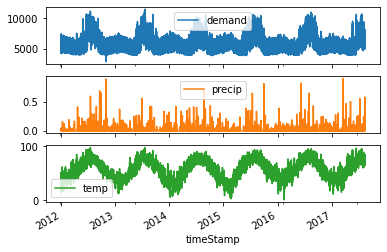

In [8]:
ny_df.plot(subplots=True)

In [9]:
ny_df.resample('D').mean()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f427ce884d0>,
      dtype=object)

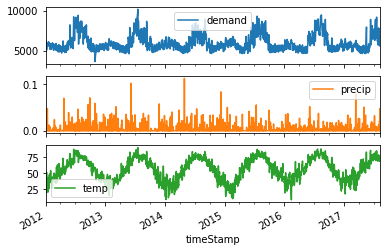

In [10]:
ny_df.resample('D').mean().plot(subplots=True)

In [11]:
ny_df_daily=ny_df.resample('D').mean()

In [12]:
from fbprophet import Prophet

In [13]:
ny_df_final=ny_df_daily.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'}, axis='columns')

In [14]:
ny_df_final.head()

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833


In [15]:
train=ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test=ny_df_final[(ny_df_final['ds'] > '2017-04-30')]

In [16]:
train.shape

(1947, 2)

In [17]:

test.shape

(104, 2)

In [18]:
m = Prophet(interval_width=0.95,yearly_seasonality=True)

In [19]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
m.params

{'beta': array([[-0.03474564, -0.07051982,  0.05760445,  0.04706222, -0.01404777,
         -0.00499591, -0.00387932, -0.00073284,  0.00241073, -0.00756147,
          0.00404936,  0.00483016, -0.00789882, -0.00470511,  0.00701484,
         -0.00268429, -0.00128001,  0.00170179,  0.00035188, -0.0002186 ,
         -0.02824661,  0.02385118,  0.0206227 ,  0.00054777, -0.00494972,
         -0.00501049]]),
 'delta': array([[-3.50360674e-09, -1.32489168e-02, -7.74174578e-02,
          2.56670913e-08,  8.81258464e-08, -1.46805043e-08,
          1.70635442e-08, -2.64450633e-08, -5.82121639e-08,
          5.89599724e-08, -5.16647027e-02, -5.73312969e-02,
         -5.10303343e-05,  3.64173165e-08,  2.05843529e-01,
          5.29272199e-02, -1.73045352e-07, -8.36841050e-02,
         -7.56589140e-02,  3.12992747e-08, -2.32275699e-08,
          1.07689546e-08,  2.03120136e-02,  2.96291061e-03,
          2.74957150e-08]]),
 'k': array([[0.08260908]]),
 'm': array([[0.5937986]]),
 'sigma_obs': array([[

In [21]:
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7592.967315,6614.912462,8519.675203
2047,2017-08-09,7582.126815,6679.531662,8452.121426
2048,2017-08-10,7536.891048,6706.239358,8435.258009
2049,2017-08-11,7492.155420,6598.949088,8398.853497
2050,2017-08-12,6917.407396,6015.097866,7837.789654


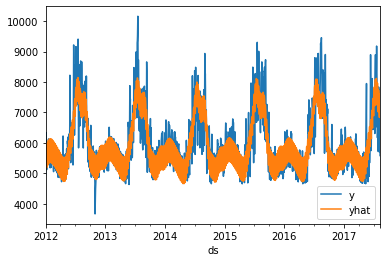

In [23]:
pd.concat([ny_df_final.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

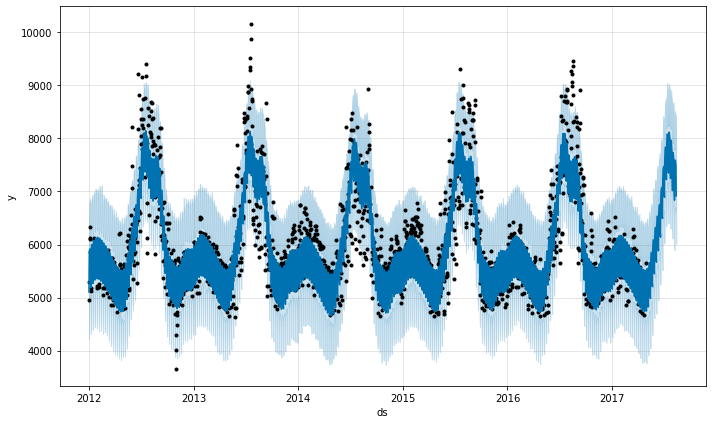

In [24]:
fig1 = m.plot(forecast)

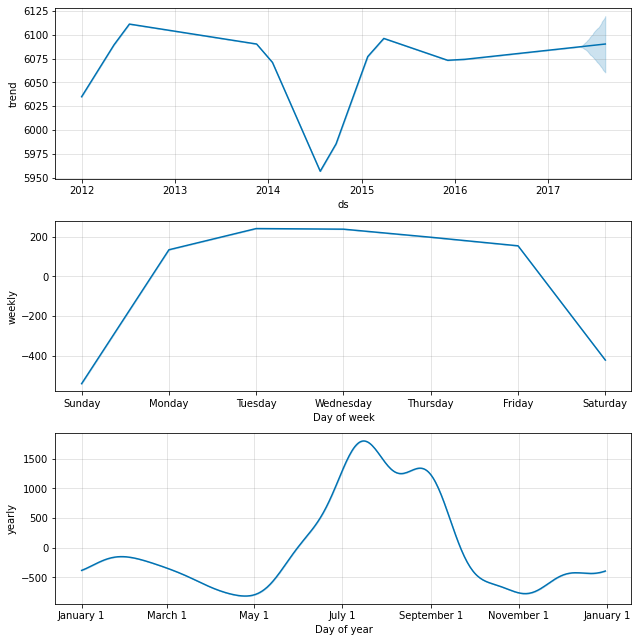

In [25]:
fig2 = m.plot_components(forecast)

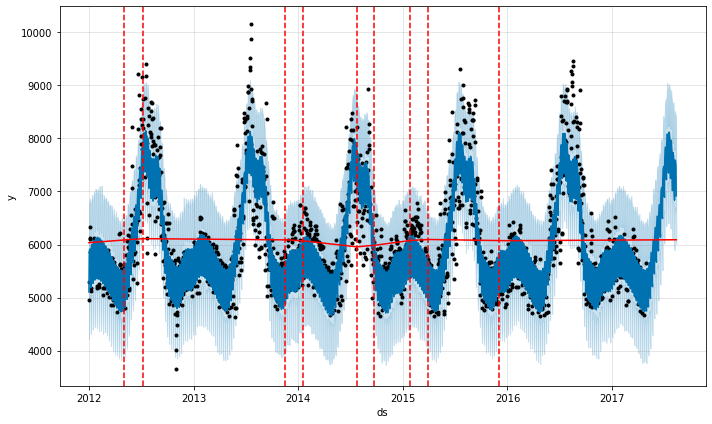

In [26]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [27]:

deltas = m.params['delta'].mean(0)
deltas

array([-3.50360674e-09, -1.32489168e-02, -7.74174578e-02,  2.56670913e-08,
        8.81258464e-08, -1.46805043e-08,  1.70635442e-08, -2.64450633e-08,
       -5.82121639e-08,  5.89599724e-08, -5.16647027e-02, -5.73312969e-02,
       -5.10303343e-05,  3.64173165e-08,  2.05843529e-01,  5.29272199e-02,
       -1.73045352e-07, -8.36841050e-02, -7.56589140e-02,  3.12992747e-08,
       -2.32275699e-08,  1.07689546e-08,  2.03120136e-02,  2.96291061e-03,
        2.74957150e-08])

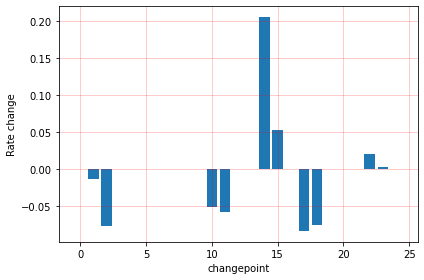

In [28]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('changepoint')
fig.tight_layout()

In [29]:
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


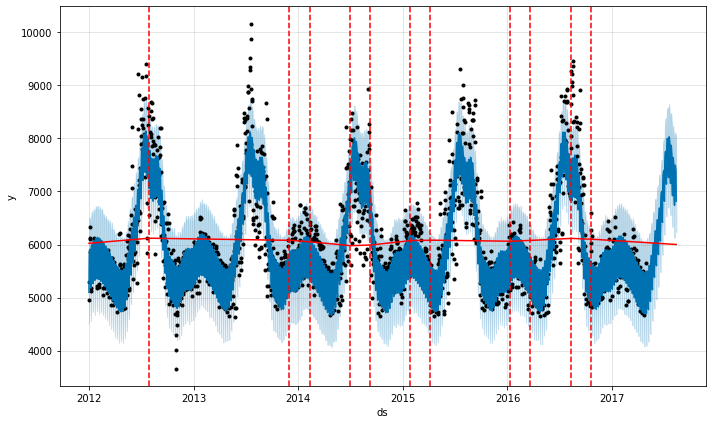

In [30]:
pro_change= Prophet(changepoint_range = 0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [31]:

from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [32]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


In [33]:

cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5562.299764,4763.552475,6382.299743,5460.325000,2014-05-01
1,2014-05-03,4972.355598,4137.350612,5828.750580,4893.683333,2014-05-01
2,2014-05-04,4848.530878,4083.573374,5629.062487,4764.137500,2014-05-01
3,2014-05-05,5529.479383,4659.851000,6378.830528,5406.762500,2014-05-01
4,2014-05-06,5624.452824,4856.538114,6453.779206,5409.750000,2014-05-01


In [34]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,253323.890470,503.312915,407.780697,0.073314,0.065546,0.890110
1,37 days 00:00:00,260083.383209,509.983709,415.161223,0.074599,0.066415,0.884615
2,37 days 12:00:00,262430.427705,512.279638,418.571701,0.075186,0.067624,0.884615
3,38 days 00:00:00,265227.392660,515.002323,421.686799,0.075451,0.068394,0.884615
4,38 days 12:00:00,268970.688046,518.623841,426.940376,0.076290,0.068828,0.884615
...,...,...,...,...,...,...,...
653,363 days 00:00:00,264075.407243,513.882678,450.853098,0.083226,0.082754,0.983516
654,363 days 12:00:00,265804.003277,515.561833,451.938016,0.083418,0.083504,0.983516
655,364 days 00:00:00,270233.232488,519.839622,455.544228,0.084268,0.084394,0.983516
656,364 days 12:00:00,270297.998974,519.901913,455.257718,0.084253,0.084394,0.983516
